In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from glob import glob

In [3]:
review_df = pd.read_feather('reviews_dataset.feather')
stock_df = pd.read_parquet("Data/financial_data.parquet")

review_df['date'] = [pd.to_datetime(date) for date in review_df.date]
review_df['year'] = [date.year for date in review_df.date]

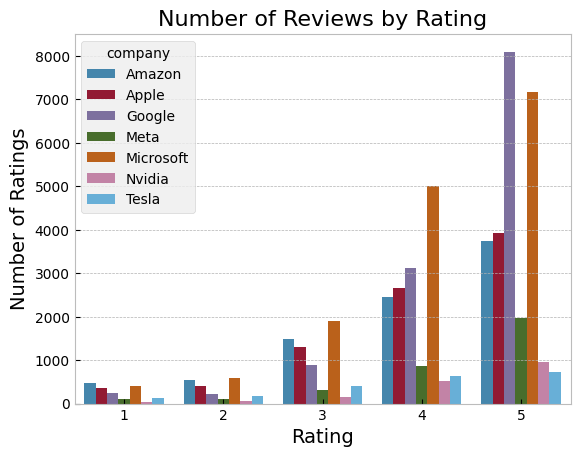

In [4]:
plt.style.use('bmh')
ax = sns.countplot(x="rating", data=review_df, hue='company', order=[1, 2, 3, 4, 5])
ax.set_facecolor("white")
ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Number of Ratings', fontsize=14)
ax = ax.set_title('Number of Reviews by Rating', fontsize=16)
plt.savefig("reviews-by-rating.png")

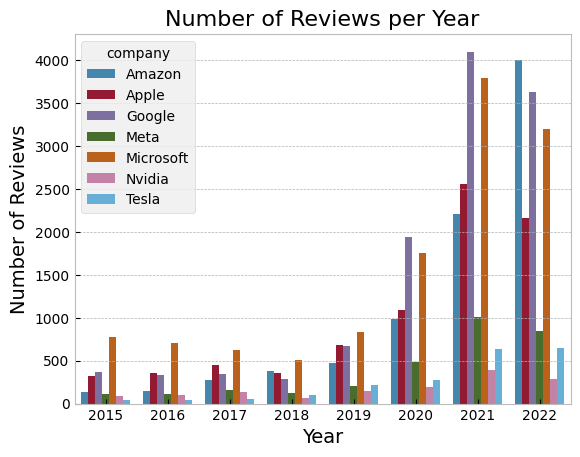

In [5]:
plt.style.use('bmh')
ax = sns.countplot(x="year", data=review_df[review_df.year > 2014], hue='company')
ax.set_facecolor("white")
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)
ax = ax.set_title('Number of Reviews per Year', fontsize=16)
plt.savefig("reviews-by-year.png")

# Annotation Visualisation

In [6]:
def load_anno(data_dir: str = "anno/", verbose: bool = False) -> pd.DataFrame:
    dfs = []
    c = 0
    for file in glob(data_dir + "*.csv"):
        if verbose:
            print(f"Reading in:   {file}")
        test = pd.read_csv(file)
        name = file.split("/")[1].split(".")[0]
        test["name"] = name
        dfs.append(test)
        c += 1

    if verbose: 
        print(f"Loaded {c} files")

    concat_df = pd.concat(dfs)
    return concat_df.reset_index().iloc[:, 1:]

In [7]:
annotation = load_anno()
annotation["sentiment"] = annotation.label.str.split("#")
annotation[["anno_rating", "sentiment"]] = annotation.sentiment.apply(pd.Series)
annotation["anno_rating"] = annotation.anno_rating.apply(int)
review_df["model_sentiment"] = review_df["sentiment"]
review_df.drop(columns=["sentiment"], inplace=True)
review_df["advice"].fillna("", inplace=True)
review_df["text"] = "Title: \n" + review_df["review_title"] + "\n Pros: \n" + review_df["pros"] + "\n Cons: \n" + review_df["cons"] + "\n Advice: \n" + review_df["advice"]
review_df["text"] = [txt.replace("\r", "") for txt in review_df.text]

merged_tmp = annotation.merge(review_df, on=["text"]).drop_duplicates()

agg_senti = merged_tmp.groupby('text', as_index=False)['sentiment'].agg(pd.Series.mode)
agg_senti["agg_sentiment"] = [x[0] if isinstance(x, np.ndarray) else x for x in agg_senti.sentiment]

agg_anno = merged_tmp.groupby('text', as_index=False).mean('anno_rating')
agg_anno['agg_anno'] = [round(rating) for rating in agg_anno.anno_rating]

merged = merged_tmp.merge(agg_anno[['text', 'agg_anno']], on=["text"]).drop_duplicates()
merged = merged.merge(agg_senti[['text', 'agg_sentiment']], on=["text"]).drop_duplicates()

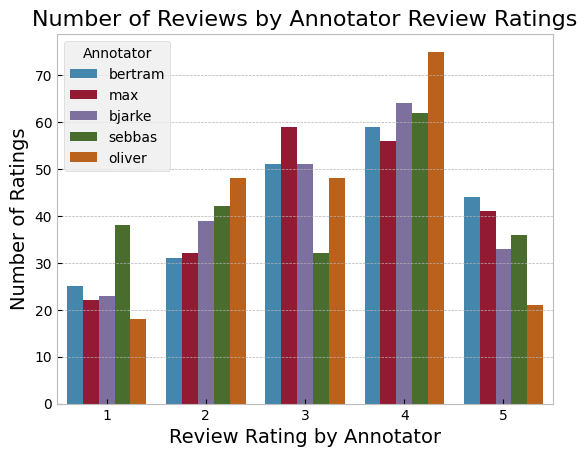

In [9]:
plt.style.use('bmh')
ax = sns.countplot(x="anno_rating", data=merged, hue='name', order=[1, 2, 3, 4, 5])
ax.set_facecolor("white")
ax.set_xlabel('Review Rating by Annotator', fontsize=14)
ax.set_ylabel('Number of Ratings', fontsize=14)
plt.legend(title='Annotator', loc='upper left')
ax = ax.set_title('Number of Reviews by Annotator Review Ratings', fontsize=16)
plt.savefig("reviews-by-annotator-rating.png")

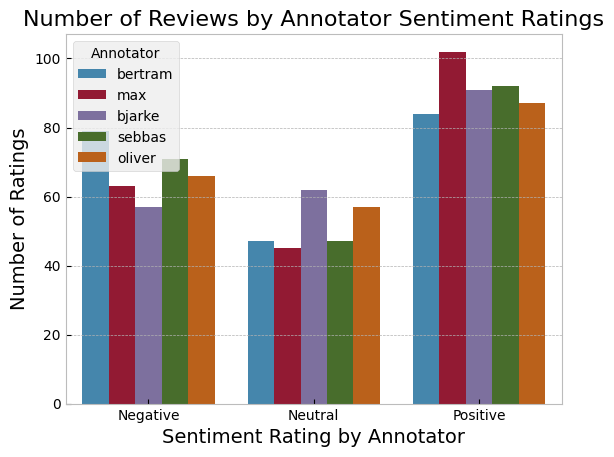

In [8]:
plt.style.use('bmh')
ax = sns.countplot(x="sentiment", data=merged, hue='name', order=['negative', 'neutral', 'Positive'])
ax.set_facecolor("white")
ax.set_xlabel('Sentiment Rating by Annotator', fontsize=14)
ax.set_ylabel('Number of Ratings', fontsize=14)
plt.legend(title='Annotator', loc='upper left')
plt.xticks([0, 1, 2],['Negative', 'Neutral', 'Positive'])
ax = ax.set_title('Number of Reviews by Annotator Sentiment Ratings', fontsize=16)
plt.savefig("reviews-by-annotator-sentiment-rating.png")